<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Insolvenzverfahren**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import LSTM, Dense

print('Tensorflow version %s' % tf.__version__)

!pip install --quiet ipython-autotime pandas_gbq
%load_ext autotime

Tensorflow version 2.4.1
time: 6.75 ms (started: 2021-05-12 19:38:58 +00:00)


## **Load Data**

In [ ]:
url = 'https://raw.githubusercontent.com/deltorobarba/repo/master/sh_unmelt_bq_raw.csv'
sh_unmelt_bq_raw = pd.read_csv(url)
sh_unmelt_bq_raw = sh_unmelt_bq_raw.sort_values('datum')
sh_unmelt_bq_raw.head()

,datum,Baugewerbe,Bergbau,Dienstleistungen,Energieversorgung,Erziehung,Finanzleistungen,Gastgewerbe,IT,Manufaktur,Sonstiges,Sozialwesen,Verkehr,Wohnungswesen
139,2008-01-01 00:00:00 UTC,15,0,6,1,1,3,8,1,9,5,3,4,0
23,2008-02-01 00:00:00 UTC,11,0,4,0,0,1,3,1,4,4,6,7,2
125,2008-03-01 00:00:00 UTC,11,0,4,1,1,1,6,5,3,3,3,6,1
66,2008-04-01 00:00:00 UTC,22,0,1,0,0,7,5,0,5,2,2,7,1
67,2008-05-01 00:00:00 UTC,22,0,3,0,0,0,2,2,1,2,2,7,2


time: 83.6 ms (started: 2021-05-12 19:41:08 +00:00)


In [ ]:
dataset = sh_unmelt_bq_raw.copy()
dataset = dataset.drop(columns=['Bergbau', 'Dienstleistungen', 'Energieversorgung',
                                'Erziehung', 'Finanzleistungen', 'Gastgewerbe',
                                'IT', 'Manufaktur', 'Sonstiges',
                                'Sozialwesen', 'Verkehr', 'Wohnungswesen'])
dataset

,datum,Baugewerbe
139,2008-01-01 00:00:00 UTC,15
23,2008-02-01 00:00:00 UTC,11
125,2008-03-01 00:00:00 UTC,11
66,2008-04-01 00:00:00 UTC,22
67,2008-05-01 00:00:00 UTC,22
...,...,...
31,2020-04-01 00:00:00 UTC,11
37,2020-05-01 00:00:00 UTC,12
3,2020-06-01 00:00:00 UTC,5
7,2020-07-01 00:00:00 UTC,6


time: 21.8 ms (started: 2021-05-12 19:41:17 +00:00)


#### **Set input data**

In [ ]:
# Set data
data = dataset.copy()

# Set seed for reproducibility
tf.random.set_seed(7)

time: 1.66 ms (started: 2021-05-12 19:41:33 +00:00)


#### **Normalize input data**

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(data)

ValueError: ignored

time: 300 ms (started: 2021-05-12 19:41:35 +00:00)


In [ ]:
print(dataset.shape)
# print(dataset.dtype)

(152, 1)
time: 1.65 ms (started: 2021-05-12 13:20:52 +00:00)


In [ ]:
# Display dataset
data [0:10] # Display first 10 values

array([[0.6 ],
       [0.44],
       [0.44],
       [0.88],
       [0.88],
       [0.52],
       [0.6 ],
       [0.52],
       [0.48],
       [0.52]])

time: 2.72 ms (started: 2021-05-12 13:20:52 +00:00)


#### **Train & Test Split**

In [ ]:
# Train & Test Split in % of complete dataset
split = 0.8
train_size = int(len(data) * split)
test_size = len(dataset) - train_size
train, test = data[0:train_size,:], data[train_size:len(dataset),:]

time: 701 µs (started: 2021-05-12 13:20:52 +00:00)


In [ ]:
train [0:10] # Display first 10 values

array([[0.6 ],
       [0.44],
       [0.44],
       [0.88],
       [0.88],
       [0.52],
       [0.6 ],
       [0.52],
       [0.48],
       [0.52]])

time: 2.96 ms (started: 2021-05-12 13:20:52 +00:00)


In [ ]:
test [0:10] # Display first 10 values

array([[0.52],
       [0.24],
       [0.44],
       [0.32],
       [0.6 ],
       [0.2 ],
       [0.6 ],
       [0.32],
       [0.28],
       [0.48]])

time: 2.21 ms (started: 2021-05-12 13:20:52 +00:00)


Now train & test data have been separated. 

We need to divide by feature input (X) and prediction variable (Y).

For both train and test dataset

#### **Window & Reshape**

In [ ]:
window = 3 # Use (t), (t-1) and (t-2) as input variables X
features = 1 # we have only one time series

time: 442 µs (started: 2021-05-12 13:20:53 +00:00)


In [ ]:
# Convert an array of values into a dataset matrix
def create_dataset(data, window=window):
    dataX, dataY = [], []
    for i in range(len(data)-window-1):
        a = data[i:(i+window), 0]
        dataX.append(a)
        dataY.append(data[i + window, 0])
    return np.array(dataX), np.array(dataY)

# X is input data = value (at t, and t-1, t-2, depending on window size)
# Y is target data = value at t+1
# Each is additionally divided into train and test set

time: 831 µs (started: 2021-05-12 13:20:53 +00:00)


In [ ]:
# Reshape into X=t and Y=t+1 and get as arrays
trainX, trainY = create_dataset(train, window)
testX, testY = create_dataset(test, window)

time: 844 µs (started: 2021-05-12 13:20:53 +00:00)


In [ ]:
print(trainX.shape)

(117, 3)
time: 588 µs (started: 2021-05-12 13:20:53 +00:00)


In [ ]:
print(trainY.shape)

(117,)
time: 1.15 ms (started: 2021-05-12 13:20:54 +00:00)


In [ ]:
# X input has 3 (= window size) values at each step
trainX [0:10] # Display first 10 values

array([[0.6 , 0.44, 0.44],
       [0.44, 0.44, 0.88],
       [0.44, 0.88, 0.88],
       [0.88, 0.88, 0.52],
       [0.88, 0.52, 0.6 ],
       [0.52, 0.6 , 0.52],
       [0.6 , 0.52, 0.48],
       [0.52, 0.48, 0.52],
       [0.48, 0.52, 0.84],
       [0.52, 0.84, 0.52]])

time: 2.93 ms (started: 2021-05-12 13:20:54 +00:00)


In [ ]:
# Y output has here only one value (t+1) at each step
trainY

array([0.88, 0.88, 0.52, 0.6 , 0.52, 0.48, 0.52, 0.84, 0.52, 0.64, 0.96,
       0.6 , 0.6 , 0.72, 0.64, 0.52, 0.6 , 0.6 , 0.2 , 0.64, 0.44, 0.32,
       0.52, 0.84, 0.64, 0.72, 0.48, 0.56, 1.  , 0.48, 0.6 , 0.48, 0.56,
       0.44, 0.52, 0.44, 0.64, 0.64, 0.92, 0.6 , 0.44, 0.44, 0.4 , 0.68,
       0.48, 0.68, 0.6 , 0.48, 0.64, 0.68, 0.48, 0.48, 0.4 , 0.64, 0.32,
       0.36, 0.76, 0.36, 0.28, 0.44, 0.44, 0.72, 0.24, 0.36, 0.6 , 0.36,
       0.52, 0.76, 0.64, 0.6 , 0.44, 0.36, 0.4 , 0.4 , 0.32, 0.32, 0.48,
       0.32, 0.16, 0.36, 0.44, 0.52, 0.  , 0.6 , 0.24, 0.24, 0.56, 0.48,
       0.56, 0.52, 0.4 , 0.52, 0.48, 0.24, 0.24, 0.44, 0.28, 0.56, 0.64,
       0.52, 0.44, 0.52, 0.4 , 0.68, 0.24, 0.52, 0.32, 0.52, 0.76, 0.36,
       0.6 , 0.6 , 0.36, 0.48, 0.48, 0.56, 0.28])

time: 4.31 ms (started: 2021-05-12 13:20:54 +00:00)


In [ ]:
trainX.shape[0]

117

time: 1.91 ms (started: 2021-05-12 13:20:54 +00:00)


In [ ]:
trainX.shape[1]

3

time: 2.38 ms (started: 2021-05-12 13:20:54 +00:00)


#### **Reshape Data Format for LSTM**

In [ ]:
# Reshape Data Format for LSTM (simple model)

# Data is in shape **[samples, features]**. LSTM expects **[samples, time steps, features]**
# Reminder 2D array: shape (n,m), n [0] = rows (time steps), m [1] = column(s)
# Shape: First Block: t, t+1, t+2. Second: t+1, t+2, t+3. Third: t+2, t+3, t+4.
# Approach 1: Use past observations as separate input features =(trainX.shape[0], features, trainX.shape[1])

trainX = np.reshape(trainX, (trainX.shape[0], features, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], features, testX.shape[1]))

time: 912 µs (started: 2021-05-12 13:20:55 +00:00)


In [ ]:
# Approach 2: Use past observations as time steps of the one input feature

# trainX = tf.reshape(trainX, (trainX.shape[0], trainX.shape[1], features))
# testX = tf.reshape(testX, (testX.shape[0], testX.shape[1], features))
# trainX

time: 290 µs (started: 2021-05-12 13:20:55 +00:00)


In [ ]:
print(trainX.shape)

(117, 1, 3)
time: 445 µs (started: 2021-05-12 13:20:55 +00:00)


In [ ]:
trainX [0:10] # Display first 10 values

array([[[0.6 , 0.44, 0.44]],

       [[0.44, 0.44, 0.88]],

       [[0.44, 0.88, 0.88]],

       [[0.88, 0.88, 0.52]],

       [[0.88, 0.52, 0.6 ]],

       [[0.52, 0.6 , 0.52]],

       [[0.6 , 0.52, 0.48]],

       [[0.52, 0.48, 0.52]],

       [[0.48, 0.52, 0.84]],

       [[0.52, 0.84, 0.52]]])

time: 2.76 ms (started: 2021-05-12 13:20:55 +00:00)


In [ ]:
print(testX.shape)

(27, 1, 3)
time: 647 µs (started: 2021-05-12 13:20:55 +00:00)


In [ ]:
# Set Hyperparameter
optimizer = tf.keras.optimizers.Adam(0.0001)
loss = 'mean_squared_error'
activation = 'relu'
epochs = 10
verbose = 1
units = 10 # internal LSTM units
repeat = 1

time: 678 µs (started: 2021-05-12 13:20:56 +00:00)


In [ ]:
model = keras.Sequential(name="my_sequential")

# https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

# Add a LSTM layer with internal units.
model.add(layers.LSTM(units, input_shape=(1, window), activation=activation, name="layer1"))

# Add a Dense layer with 10 units.
model.add(layers.Dense(1, name="layer2"))

# Call model on a test input
trainY = model(trainX)

time: 76.8 ms (started: 2021-05-12 13:20:56 +00:00)


In [ ]:
model.summary()

Model: "my_sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (LSTM)                (None, 10)                560       
_________________________________________________________________
layer2 (Dense)               (None, 1)                 11        
Total params: 571
Trainable params: 571
Non-trainable params: 0
_________________________________________________________________
time: 2.11 ms (started: 2021-05-12 13:20:56 +00:00)


In [ ]:
trainY.shape

TensorShape([117, 1])

time: 2.27 ms (started: 2021-05-12 13:21:00 +00:00)


In [ ]:
# model.weights

time: 337 µs (started: 2021-05-12 13:21:00 +00:00)


In [ ]:
print("Number of weights after calling the model:", len(model.weights))

Number of weights after calling the model: 5
time: 874 µs (started: 2021-05-12 13:21:00 +00:00)


In [ ]:
model.compile(loss=loss, 
              optimizer=optimizer, 
              metrics=['accuracy'])

time: 8.44 ms (started: 2021-05-12 13:21:03 +00:00)


In [ ]:
# Prepare visualisation - Plot Losses Keras TF (simple)
!pip install livelossplot --quiet
from livelossplot import PlotLossesKerasTF

# Select visualization method
callbacks = [PlotLossesKerasTF()]

time: 2.08 s (started: 2021-05-12 13:21:04 +00:00)


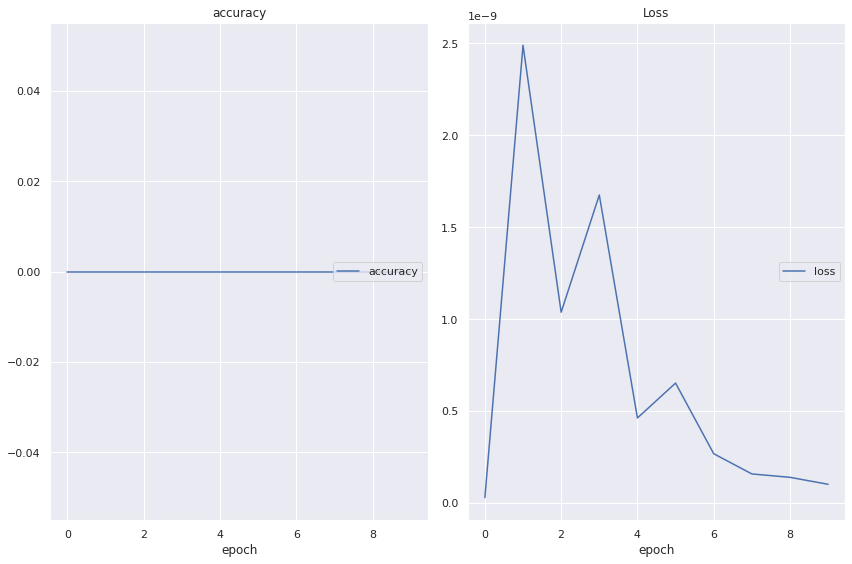

accuracy
	accuracy         	 (min:    0.000, max:    0.000, cur:    0.000)
Loss
	loss             	 (min:    0.000, max:    0.000, cur:    0.000)
4/4 [==============================] - 1s 133ms/step - loss: 1.0139e-10 - accuracy: 0.0000e+00


time: 8.06 s (started: 2021-05-12 13:21:06 +00:00)


In [ ]:
# Train model
model.fit(trainX,
          trainY, 
          epochs=epochs, 
          verbose=verbose, 
          shuffle=False, 
          callbacks=callbacks)

#### **Make Predictions**

In [ ]:
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

time: 567 ms (started: 2021-05-12 13:21:21 +00:00)


#### **Predictions (Train & Test)**

**Test Predict**

In [ ]:
testPredict [0:10]

array([[0.01991221],
       [0.00783165],
       [0.01825965],
       [0.0110531 ],
       [0.01812537],
       [0.00492398],
       [0.02196703],
       [0.01381726],
       [0.00926913],
       [0.01684139]], dtype=float32)

time: 3.12 ms (started: 2021-05-12 13:21:24 +00:00)


In [ ]:
testPredict = scaler.inverse_transform(testPredict)
testPredict [0:10]

array([[0.49780533],
       [0.19579117],
       [0.45649117],
       [0.27632746],
       [0.45313415],
       [0.12309944],
       [0.5491758 ],
       [0.34543154],
       [0.23172821],
       [0.42103487]], dtype=float32)

time: 2.99 ms (started: 2021-05-12 13:21:26 +00:00)


**Train Predict**

In [ ]:
trainPredict [0:10]

array([[0.02494091],
       [0.01862988],
       [0.0186746 ],
       [0.03473179],
       [0.03734374],
       [0.02000537],
       [0.02427826],
       [0.02099016],
       [0.02061545],
       [0.01885881]], dtype=float32)

time: 2.67 ms (started: 2021-05-12 13:21:32 +00:00)


In [ ]:
trainPredict = scaler.inverse_transform(trainPredict)
trainPredict [0:10]

array([[0.6235228 ],
       [0.46574688],
       [0.46686506],
       [0.86829466],
       [0.93359363],
       [0.5001343 ],
       [0.60695654],
       [0.52475405],
       [0.5153863 ],
       [0.47147012]], dtype=float32)

time: 3.7 ms (started: 2021-05-12 13:21:34 +00:00)


#### **Actual (Train & Test)**

**Test Actual**

In [ ]:
testY [0:10]

array([0.32, 0.6 , 0.2 , 0.6 , 0.32, 0.28, 0.48, 0.2 , 0.48, 0.28])

time: 3.24 ms (started: 2021-05-12 13:21:38 +00:00)


In [ ]:
testY = scaler.inverse_transform([testY])
testY [0:10]

array([[ 8., 15.,  5., 15.,  8.,  7., 12.,  5., 12.,  7.,  9., 13., 10.,
         8.,  7.,  6.,  7.,  9., 10., 11.,  8.,  6.,  4., 11., 12.,  5.,
         6.]])

time: 2.39 ms (started: 2021-05-12 13:21:38 +00:00)


**Train Actual**

In [ ]:
trainY [0:10]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.02494378],
       [0.01863045],
       [0.01867562],
       [0.03473447],
       [0.03734652],
       [0.02000794],
       [0.02428099],
       [0.02099269],
       [0.02061593],
       [0.01886141]], dtype=float32)>

time: 3.05 ms (started: 2021-05-12 13:21:39 +00:00)


In [ ]:
# Convert / Create a numpy ndarray from a tensor
trainY = tf.make_tensor_proto(trainY)  # convert `tensor a` to a proto tensor
trainY = tf.make_ndarray(trainY)
trainY [0:10]

array([[0.02494378],
       [0.01863045],
       [0.01867562],
       [0.03473447],
       [0.03734652],
       [0.02000794],
       [0.02428099],
       [0.02099269],
       [0.02061593],
       [0.01886141]], dtype=float32)

time: 2.97 ms (started: 2021-05-12 13:21:39 +00:00)


In [ ]:
trainY.shape

(117, 1)

time: 2.23 ms (started: 2021-05-12 13:21:39 +00:00)


In [ ]:
#trainY = scaler.inverse_transform([trainY])
#trainY [0:10]

time: 286 µs (started: 2021-05-12 13:21:39 +00:00)


#### **Residuals**

In [ ]:
# Get residuals
residuals = (testY[0] - testPredict[:,0])
res = pd.DataFrame(data=residuals, columns=['residuals'])
res.head()

,residuals
0,7.502195
1,14.804209
2,4.543509
3,14.723673
4,7.546866


time: 6.48 ms (started: 2021-05-12 13:21:40 +00:00)


<AxesSubplot:title={'center':'Residuals'}>

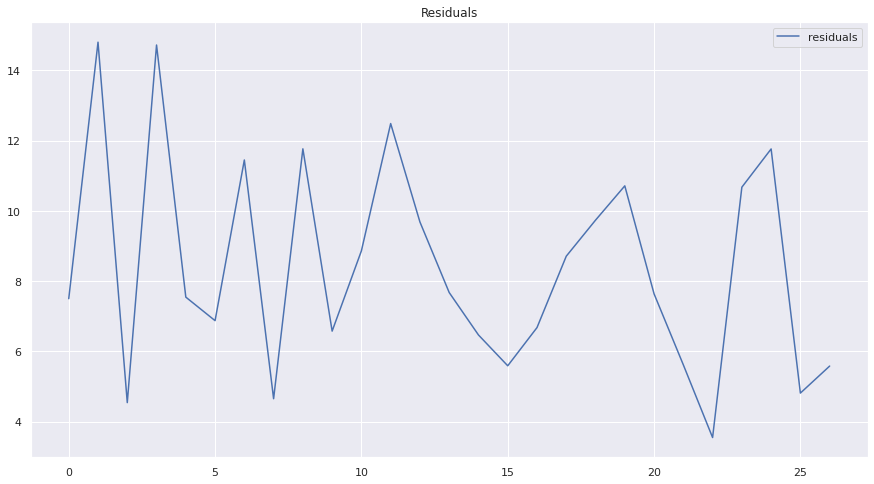

time: 195 ms (started: 2021-05-12 13:21:41 +00:00)


In [ ]:
# Plot Residuals
sns.set(rc={'figure.figsize':(15, 8)})
res.plot(title='Residuals')

#### **Calculate RMSE & Plot**

In [ ]:
# Calculate RMSE
import math
from sklearn.metrics import mean_squared_error

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

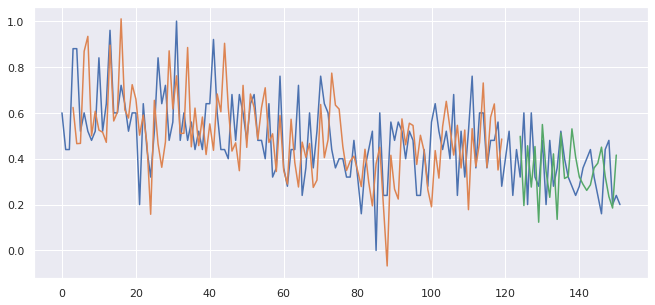

time: 178 ms (started: 2021-05-12 13:21:45 +00:00)


In [ ]:
# Plot results

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window:len(trainPredict)+window, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(window*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
sns.set(rc={'figure.figsize':(11, 5)})
#plt.plot(scaler.inverse_transform(dataset))
plt.plot(data)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()